# Multi Layer Perceptron model using Sklearn

## Importing necessary libs

In [276]:
import numpy as np
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression

## Helper functions
We will be working with sqlite database to get our data. So these will be our helper functions to get and close connections

In [17]:
def get_connection():
    conn =  sqlite3.connect("../Datasets/mental_health.sqlite")
    cur = conn.cursor()
    return conn,cur
def close_connection(conn,cursor):
    cursor.close()
    conn.close()

This function helps us maintain clean code. Takes as input the table name and returns the table info as a dataframe 

In [31]:
def get_dataframe(tbl_name):
    conn,cur = get_connection()
    cur.execute("SELECT * FROM "+tbl_name)
    results = pd.DataFrame(cur.fetchall())
    cur.execute("PRAGMA table_info("+tbl_name+")")
    headings = cur.fetchall()
    close_connection(conn,cur)
    col_names = [heading[1] for heading in headings]
    results.columns = col_names
    return results


## Getting the data
The database contains three tables - Answer,Question and Survey <br>
Get the data here : https://www.kaggle.com/anth7310/mental-health-in-the-tech-industry

In [34]:
answers = get_dataframe("Answer")
question = get_dataframe("Question")
survey = get_dataframe("Survey")

In [33]:
answers

,AnswerText,SurveyID,UserID,QuestionID
0,37,2014,1,1
1,44,2014,2,1
2,32,2014,3,1
3,31,2014,4,1
4,31,2014,5,1
...,...,...,...,...
236893,Other,2016,2689,117
236894,Support,2016,2690,117
236895,Back-end Developer,2016,2691,117
236896,DevOps/SysAdmin,2016,2692,117


In [35]:
question

,questiontext,questionid
0,What is your age?,1
1,What is your gender?,2
2,What country do you live in?,3
3,"If you live in the United States, which state ...",4
4,Are you self-employed?,5
...,...,...
100,Do you think that team members/co-workers woul...,114
101,"If yes, what condition(s) have you been diagno...",115
102,"If maybe, what condition(s) do you believe you...",116
103,Which of the following best describes your wor...,117


In [36]:
survey

,SurveyID,Description
0,2014,mental health survey for 2014
1,2016,mental health survey for 2016
2,2017,mental health survey for 2017
3,2018,mental health survey for 2018
4,2019,mental health survey for 2019


As we can see, he data is in normalized form. We need to build a dataset from this database. <br>
We will be using sqlite3 package. <br>
Check out a few questions in the database. These will be our attributes

In [43]:
for i in range(10):
    print(question.iloc[i]["questiontext"])

What is your age?
What is your gender?
What country do you live in?
If you live in the United States, which state or territory do you live in?
Are you self-employed?
Do you have a family history of mental illness?
Have you ever sought treatment for a mental health disorder from a mental health professional?
How many employees does your company or organization have?
Is your employer primarily a tech company/organization?
Does your employer provide mental health benefits as part of healthcare coverage?


## Exploring the data
## How many records are there for each surveyID (Or year) ?
This tells us whether there were equal number of records or not, essentially pointing us in the direction of the finding out whether there were equal number of questions and users in all of the surveys <br>
The answer is no. There are a different number of records for each survey implying that there are either different number of users answering the questions or that there are different number of questions in each survey or both

In [118]:
conn,cur = get_connection()
count_surveys = list()
for i in survey["SurveyID"].values:
    cur.execute("SELECT COUNT(*) FROM Answer WHERE SurveyID = "+str(i))
    res = cur.fetchall()
    print(res[0])
    count_surveys.append(res[0][0])
close_connection(conn,cur)


(32760,)
(88238,)
(57456,)
(31692,)
(26752,)


## How many Questions are there in each SurveyID ?
Each survey has a different number of questions, although the later surveys use uniform number of questions. This makes finding attributes quite tricky. Because we need to find all of the questions that have been answered by all of the users.

In [82]:
conn,cur = get_connection()
count_questions = list()
for i in survey["SurveyID"].values:
    cur.execute("SELECT COUNT(DISTINCT QuestionID) FROM Answer WHERE SurveyID = "+str(i))
    res = cur.fetchall()
    print(res[0])
    count_questions.append(res[0][0])
close_connection(conn,cur)

(26,)
(60,)
(76,)
(76,)
(76,)


## How many Users were there in each Survey ?
Here we see that each survey had a different number of users/participants.
<br>The next question is finding the total number of unique users.

In [83]:
conn,cur = get_connection()
count_users = list()
for i in survey["SurveyID"].values:
    cur.execute("SELECT COUNT(DISTINCT UserID) FROM Answer WHERE SurveyID = "+str(i))
    res = cur.fetchall()
    print(res[0])
    count_users.append(res[0][0])
close_connection(conn,cur)

(1260,)
(1433,)
(756,)
(417,)
(352,)


## Findng the maximum number of unique users

In [84]:
conn,cur = get_connection()
cur.execute("SELECT MAX(UserID) FROM Answer")
print(cur.fetchall())
close_connection(conn,cur)

[(4218,)]


In [85]:
conn,cur = get_connection()
unique_users = list()
for i in survey["SurveyID"].values:
    cur.execute("SELECT DISTINCT UserID FROM Answer WHERE SurveyID = "+str(i))
    unique_users.append([user[0] for user in cur.fetchall()])
close_connection(conn,cur)

In [86]:
print([len(unique_users[i]) for i in range(5)])

[1260, 1433, 756, 417, 352]


## Helper function for finding similarity between two lists of UserID's

In [87]:
def is_same(first_list,sec_list,max_len = 4219):
    mod_flist = np.asarray([-999]*max_len)
    for i in first_list:
        mod_flist[i] = i
    mod_slist = np.asarray([0]*max_len)
    for i in sec_list:
        mod_slist[i] = i
    return mod_flist==mod_slist

### Clearly all surveys had different Users with no overlap. And hence we have 4218 unique users throughout our data.

In [88]:
for i in range(4):
    print(np.where(is_same(unique_users[i],unique_users[i+1])*1==1)[0])

[]
[]
[]
[]


## Did all of the users answer all of the distinct questions in that particular survey ?
This helps us maintain uniformity in our dataset and is very essential. <br>
If we multiply the number of distinct users with the number o distinct questions then we should arrive at the number of records in the particualr SurveyID <br>
This is true for all except the year 2016 Sruvey, where the number of records exceeds the number expected. <br>
This implies that either there are users who answered more number of questions or that there are duplicates in the data

In [93]:
for i in range(len(survey["SurveyID"].values)):
    print(count_surveys[i],(count_users[i]*count_questions[i]))

32760 32760
88238 85980
57456 57456
31692 31692
26752 26752


## How many quesions did each user in Survey2016 answer?

In [103]:
conn,cur = get_connection()
cur.execute("SELECT DISTINCT UserID FROM Answer WHERE SurveyID = 2016")
users_in_2016 = [user[0] for user in cur.fetchall()]
close_connection(conn,cur)

In [115]:
print(users_in_2016[:10],len(users_in_2016))

[1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270] 1433


In [107]:
conn,cur = get_connection()
counts = list()
for i in users_in_2016:
    cur.execute("SELECT COUNT(DISTINCT QuestionID ) FROM Answer WHERE UserID = "+str(i))
    counts.append(cur.fetchall()[0])
close_connection(conn,cur)


### Clearly all of the users answered the same number of questions, which implies that there are duplicated in the data
The set in python only accepts unique values. This is a quick and easy way to find unique values in a list structure

In [113]:
print(set(counts),len(counts))

{(60,)} 1433


## Finding duplicates
The table Answer does not have any duplicates. But the previous results imply that there are.

In [116]:
answers[answers.duplicated()]

,AnswerText,SurveyID,UserID,QuestionID


## Checking for missing values
There are no missing values that contribute to this extra number of records in Survey 2016. <br>
More evidence for existence of duplicates

In [117]:
answers.isnull().values.any()

False

### The duplicates() function finds duplicate rows in the entire dataset considering all attributes. If we remove the answer text from the dataset, this may reveal that many users have attempted the same questions more than once.

In [121]:
results = get_dataframe("Answer")

In [124]:
results = results.drop(["AnswerText"],axis = 1)

In [130]:
duplicates = results[results.duplicated()].index.tolist()

## Successfully found the duplicates

In [131]:
answers.drop(duplicates,axis = 0)

,AnswerText,SurveyID,UserID,QuestionID
0,37,2014,1,1
1,44,2014,2,1
2,32,2014,3,1
3,31,2014,4,1
4,31,2014,5,1
...,...,...,...,...
236893,Other,2016,2689,117
236894,Support,2016,2690,117
236895,Back-end Developer,2016,2691,117
236896,DevOps/SysAdmin,2016,2692,117


## How many questions hve all of the users answered?

In [137]:
users_all_questions = list()
for i in question["questionid"].values: 
    users_all_questions.append(answers[answers["QuestionID"]==i]["UserID"].tolist())

### We can see that all of the 4218 users throughout the surveys have answered these 12 questions.
We will be using these questions as attributes

In [153]:
print(len(users_all_questions[11]))

4218


## Building the dataset
We use SQL queries to build the dataset instead of using dataframes

In [215]:
headings = ["UserID","SurveyID"]
for idx,h in enumerate(question["questionid"].values[:12].tolist()):
    headings.append(question[question["questionid"]==h]["questiontext"].values[0])


In [216]:
headings

['UserID',
 'SurveyID',
 'What is your age?',
 'What is your gender?',
 'What country do you live in?',
 'If you live in the United States, which state or territory do you live in?',
 'Are you self-employed?',
 'Do you have a family history of mental illness?',
 'Have you ever sought treatment for a mental health disorder from a mental health professional?',
 'How many employees does your company or organization have?',
 'Is your employer primarily a tech company/organization?',
 'Does your employer provide mental health benefits as part of healthcare coverage?',
 'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?',
 'Would you bring up a mental health issue with a potential employer in an interview?']

In [189]:
conn,cur = get_connection()
datalist = list()
for idx,h in enumerate(question["questionid"].values[:12].tolist()):
    cur.execute("SELECT AnswerText FROM Answer WHERE QuestionID = "+str(h)+" ORDER BY UserID")
    datalist.append([h[0] for h in cur.fetchall()])
close_connection(conn,cur)

In [191]:
len(datalist)

12

In [195]:
conn,cur = get_connection()
cur.execute("SELECT DISTINCT(UserID),SurveyID from Answer")
user_survey = [[h[0],h[1]] for h in cur.fetchall()]
close_connection(conn,cur)
len(user_survey)

4218

In [218]:
datalist = np.asarray(datalist)

In [219]:
user_survey = np.asarray(user_survey)

In [220]:
dataset = np.concatenate((user_survey,np.transpose(datalist)),axis = 1)

## Building the dataframe from SQL results

In [221]:
data = pd.DataFrame(dataset,columns = headings)

In [224]:
data.head()

,UserID,SurveyID,What is your age?,What is your gender?,What country do you live in?,"If you live in the United States, which state or territory do you live in?",Are you self-employed?,Do you have a family history of mental illness?,Have you ever sought treatment for a mental health disorder from a mental health professional?,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Does your employer provide mental health benefits as part of healthcare coverage?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,Would you bring up a mental health issue with a potential employer in an interview?
0,1,2014,37,Female,United States,Illinois,-1,No,1,6-25,1,Yes,Yes,No
1,2,2014,44,Male,United States,Indiana,-1,No,0,More than 1000,0,Don't know,Don't know,No
2,3,2014,32,Male,Canada,-1,-1,No,0,6-25,1,No,Don't know,Yes
3,4,2014,31,Male,United Kingdom,-1,-1,Yes,1,26-100,1,No,No,Maybe
4,5,2014,31,Male,United States,Texas,-1,No,0,100-500,1,Yes,Don't know,Yes


## Information about the data

In [225]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4218 entries, 0 to 4217
Data columns (total 14 columns):
 #   Column                                                                                                                                          Non-Null Count  Dtype 
---  ------                                                                                                                                          --------------  ----- 
 0   UserID                                                                                                                                          4218 non-null   object
 1   SurveyID                                                                                                                                        4218 non-null   object
 2   What is your age?                                                                                                                               4218 non-null   object
 3   What is your gender?        

## Data stats

In [226]:
data.describe()

,UserID,SurveyID,What is your age?,What is your gender?,What country do you live in?,"If you live in the United States, which state or territory do you live in?",Are you self-employed?,Do you have a family history of mental illness?,Have you ever sought treatment for a mental health disorder from a mental health professional?,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Does your employer provide mental health benefits as part of healthcare coverage?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,Would you bring up a mental health issue with a potential employer in an interview?
count,4218,4218,4218,4218,4218,4218,4218,4218,4218,4218,4218,4218,4218,4218
unique,4218,5,65,101,81,51,3,3,2,7,3,6,5,3
top,238,2016,30,Male,United States of America,-1,0,Yes,1,More than 1000,1,Yes,I don't know,No
freq,1,1433,250,2830,1853,1622,3550,1868,2412,912,2888,1744,1546,2951


## Mapping all string values to unique numbers

In [229]:
mappings = list()
for i in headings[3:6]+[headings[7]]+[headings[9]]+headings[11:15]:
    unique_vals = data[i].unique()
    unique_mapping = {unique_vals[j]:j for j in range(len(unique_vals))}
    mappings.append(unique_mapping)
    data[i] = data[i].map(unique_mapping)
data.head()

,UserID,SurveyID,What is your age?,What is your gender?,What country do you live in?,"If you live in the United States, which state or territory do you live in?",Are you self-employed?,Do you have a family history of mental illness?,Have you ever sought treatment for a mental health disorder from a mental health professional?,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Does your employer provide mental health benefits as part of healthcare coverage?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,Would you bring up a mental health issue with a potential employer in an interview?
0,1,2014,37,0,0,0,-1,0,1,0,1,0,0,0
1,2,2014,44,1,0,1,-1,0,0,1,0,1,1,0
2,3,2014,32,1,1,2,-1,0,0,0,1,2,1,1
3,4,2014,31,1,2,2,-1,1,1,2,1,2,2,2
4,5,2014,31,1,0,3,-1,0,0,3,1,0,1,1


### All mappings are stores in this list of dictionaries for future reference or converting back

In [232]:
mappings[-1]

{'No': 0, 'Yes': 1, 'Maybe': 2}

## Data Stats after conversion

In [237]:
data["UserID"] = data["UserID"].astype(int)
data["SurveyID"] = data["SurveyID"].astype(int)
data.describe()

,UserID,SurveyID,What is your gender?,What country do you live in?,"If you live in the United States, which state or territory do you live in?",Do you have a family history of mental illness?,How many employees does your company or organization have?,Does your employer provide mental health benefits as part of healthcare coverage?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,Would you bring up a mental health issue with a potential employer in an interview?
count,4218.000000,4218.000000,4218.000000,4218.000000,4218.000000,4218.000000,4218.000000,4218.000000,4218.000000,4218.000000
mean,2109.500000,2016.029872,6.260787,25.470839,8.758416,0.750593,2.417971,1.818397,1.872926,0.545993
std,1217.776047,1.587555,16.362933,22.290177,9.826607,0.703598,1.887399,1.906698,1.448989,0.859819
min,1.000000,2014.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1055.250000,2014.000000,1.000000,2.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,2109.500000,2016.000000,1.000000,21.000000,4.000000,1.000000,2.000000,1.000000,2.000000,0.000000
75%,3163.750000,2017.000000,1.000000,48.000000,14.000000,1.000000,3.000000,4.000000,3.000000,1.000000
max,4218.000000,2019.000000,100.000000,80.000000,50.000000,2.000000,6.000000,5.000000,4.000000,2.000000


## Data info after conversion

In [238]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4218 entries, 0 to 4217
Data columns (total 14 columns):
 #   Column                                                                                                                                          Non-Null Count  Dtype 
---  ------                                                                                                                                          --------------  ----- 
 0   UserID                                                                                                                                          4218 non-null   int32 
 1   SurveyID                                                                                                                                        4218 non-null   int32 
 2   What is your age?                                                                                                                               4218 non-null   object
 3   What is your gender?        

## Seperating data and target variables

In [240]:
data_X = data[[i for i in data.columns if i not in ["UserID",headings[-1]]]]
data_Y = data[headings[-1]]

In [241]:
data_X

,SurveyID,What is your age?,What is your gender?,What country do you live in?,"If you live in the United States, which state or territory do you live in?",Are you self-employed?,Do you have a family history of mental illness?,Have you ever sought treatment for a mental health disorder from a mental health professional?,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Does your employer provide mental health benefits as part of healthcare coverage?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?
0,2014,37,0,0,0,-1,0,1,0,1,0,0
1,2014,44,1,0,1,-1,0,0,1,0,1,1
2,2014,32,1,1,2,-1,0,0,0,1,2,1
3,2014,31,1,2,2,-1,1,1,2,1,2,2
4,2014,31,1,0,3,-1,0,0,3,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4213,2019,27,52,18,2,0,0,0,1,0,5,3
4214,2019,48,1,48,44,1,0,0,6,-1,4,4
4215,2019,50,1,18,2,1,0,0,6,-1,4,4
4216,2019,30,53,18,2,0,0,0,1,1,2,0


In [242]:
data_Y

0       0
1       0
2       1
3       2
4       1
       ..
4213    0
4214    2
4215    0
4216    0
4217    1
Name: Would you bring up a mental health issue with a potential employer in an interview?, Length: 4218, dtype: int64

## Splitting into train and test sets

In [245]:
train_X,test_X,train_Y,test_Y = train_test_split(data_X,data_Y,test_size = 0.2)
print(train_X.shape,train_Y.shape)
print(test_X.shape,test_Y.shape)

(3374, 12) (3374,)
(844, 12) (844,)


## Training MLP model with different activation functions. Considerbaly shallow networks

           0         1
0  69.917012  70.14218
1  69.917012  70.14218
2  69.917012  70.14218


<BarContainer object of 3 artists>

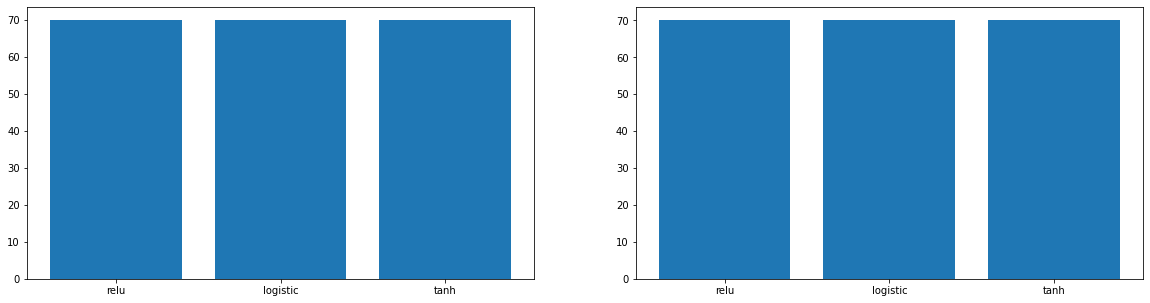

In [279]:
fig,ax = plt.subplots(1,2,figsize = (20,5))
train = list()
test = list()
for i in ["relu","logistic","tanh"]:
    network_1 = MLPClassifier((100,150,3),activation = i,solver = "adam",learning_rate = "adaptive")
    network_1.fit(train_X,train_Y)
    train.append(network_1.score(train_X,train_Y)*100)
    test.append(network_1.score(test_X,test_Y)*100)
res = pd.DataFrame([i for i in zip(train,test)])
print(res)
ax[0].bar(["relu","logistic","tanh"],res[0])
ax[1].bar(["relu","logistic","tanh"],res[1])

## Different architecture. More complex

           0         1
0  69.917012  70.14218
1  69.917012  70.14218
2  69.917012  70.14218


<BarContainer object of 3 artists>

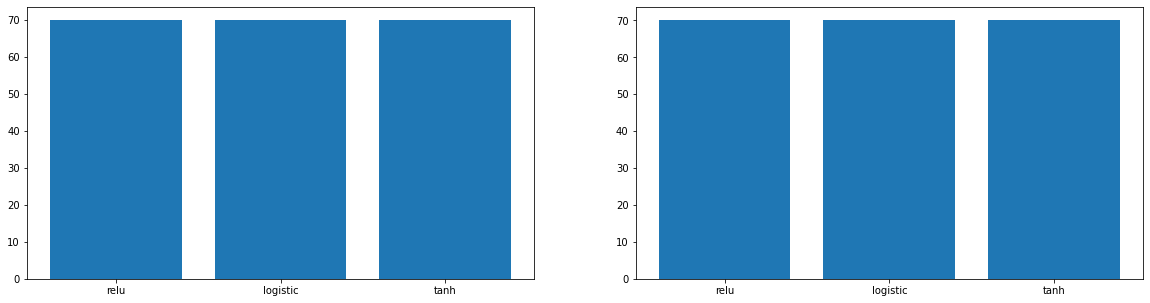

In [280]:
fig,ax = plt.subplots(1,2,figsize = (20,5))
train = list()
test = list()
for i in ["relu","logistic","tanh"]:
    network_1 = MLPClassifier((1024,512,256),activation = i,solver = "adam",learning_rate = "adaptive")
    network_1.fit(train_X,train_Y)
    train.append(network_1.score(train_X,train_Y)*100)
    test.append(network_1.score(test_X,test_Y)*100)
res_1 = pd.DataFrame([i for i in zip(train,test)])
print(res_1)
ax[0].bar(["relu","logistic","tanh"],res_1[0])
ax[1].bar(["relu","logistic","tanh"],res_1[1])

## Deep network

           0         1
0  69.917012  70.14218
1  69.917012  70.14218
2  69.917012  70.14218


<BarContainer object of 3 artists>

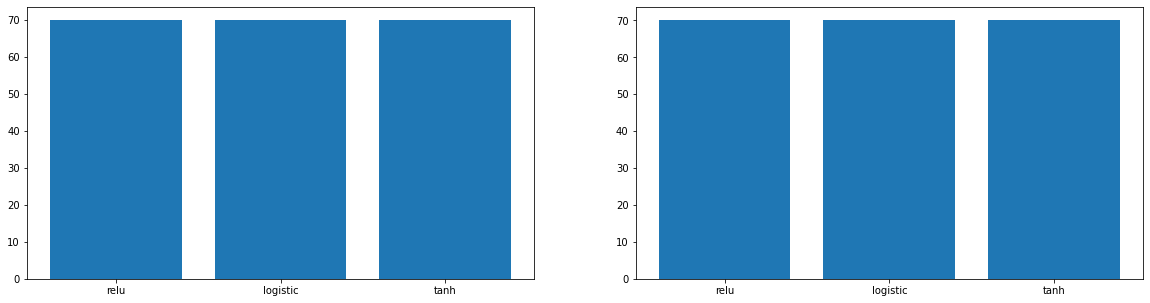

In [282]:
fig,ax = plt.subplots(1,2,figsize = (20,5))
train = list()
test = list()
for i in ["relu","logistic","tanh"]:
    network_1 = MLPClassifier((1024,512,256,128),activation = i,solver = "adam",learning_rate = "adaptive")
    network_1.fit(train_X,train_Y)
    train.append(network_1.score(train_X,train_Y)*100)
    test.append(network_1.score(test_X,test_Y)*100)
res_2 = pd.DataFrame([i for i in zip(train,test)])
print(res_2)
ax[0].bar(["relu","logistic","tanh"],res_2[0])
ax[1].bar(["relu","logistic","tanh"],res_2[1])

## MLP is capable of regression also

           0          1
0  99.999998  93.755407
1  35.824580  38.353598
2  57.122064  59.495173


<BarContainer object of 3 artists>

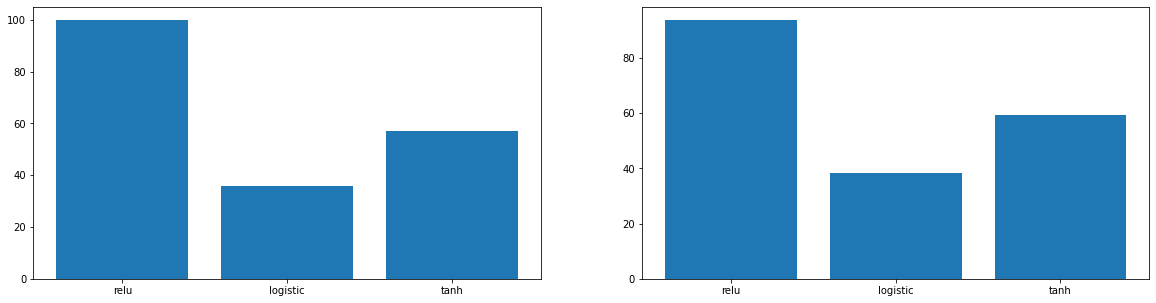

In [281]:
X, y = make_regression(n_samples=600, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1)
fig,ax = plt.subplots(1,2,figsize = (20,5))
train = list()
test = list()
for i in ["relu","logistic","tanh"]:
    network_1 = MLPRegressor((1024,512,256,128),activation = i,solver = "adam",learning_rate = "adaptive")
    network_1.fit(X_train,y_train)
    train.append(network_1.score(X_train,y_train)*100)
    test.append(network_1.score(X_test,y_test)*100)
res_3 = pd.DataFrame([i for i in zip(train,test)])
print(res_3)
ax[0].bar(["relu","logistic","tanh"],res_3[0])
ax[1].bar(["relu","logistic","tanh"],res_3[1])